# Plotting Output Conductivity
### Nicolas Guerra
### June 6, 2024
This notebook plots the conductivity produced by the trained model and compares it with the true solution.

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
import torch

In [2]:
# I will use the testing data from the following dataset to get a predicted output
data_path = "../data/FinalExperiments/Train2/Poisson_n70_L100.h5"

In [3]:
f = h5py.File(data_path, 'r')

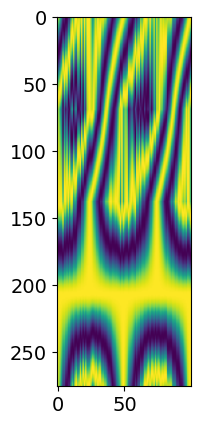

In [4]:
plt.imshow(f[f'training/sample_{18}/input_dbc'][:])
plt.show()

In [8]:
f[f'training/sample_{19}/output'][:].shape

(70, 70)

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from Problems.PoissonSin_FullDtN import MyDataset

Note:

To get the concatenated data and conductivity data from sample 0:
* Concat = test_dataset[0][0]
* Conductivity = test_dataset[0][1]

To get the grid:
* grid = train_dataset.get_grid().squeeze(0)

In [259]:
def get_output(model_name, data_path, sample_number='random'):
# This function takes in a model name (following how the folder is written in the directory) as well as
# a dataset name. This function will use the testing data from the given dataset to out put a random pair of
# predicted and true conductivities. This function will also output the sample number from the testing dataset
# INPUT: model_name (string), data_name (string)
# OUTPUT: true_conductivity (matrix), predicted_conductivity (matrix), sample_number (int)
# Read in training and testing data
    # Load Trained ModeL
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torch.load(model_name + "/model.pkl", map_location=torch.device(device))
    
    # Read in data
    # train_dataset = MyDataset(norm='norm', inputs_bool=2, device=device, which="training", mod='nio_new',data_path=data_path)
    test_dataset = MyDataset(norm='none', inputs_bool=2, device=device, which="training", mod='nio_new', noise=0, data_path=data_path)
    grid = test_dataset.get_grid().squeeze(0)
    
    # Get random sample from the testing data (there are 1024 "validation" samples)
    if sample_number == 'random':
        sample_number = np.random.randint(0, 1024)
    sample_concat = test_dataset[sample_number][0]
    # UNCOMMENT the next two lines if you would like to give only a slice of the matrix of DBC NBC data (not all 20)
    # sample_concat = sample_concat[0]
    # sample_concat=torch.reshape(sample_concat, (1, 1, 1, 8, 68)) # reshaped so it is like "1 batch"
    # AND COMMENT THE NEXT LINE
    sample_concat=torch.reshape(sample_concat, (1, 100, 1, 8, 68)) # reshaped so it is like "1 batch"
    true_conductivity = test_dataset[sample_number][1]

    if torch.cuda.is_available():
        # Move the data to GPU since model is already on GPU
        sample_concat, grid, true_conductivity = sample_concat.cuda(), grid.cuda(), true_conductivity.cuda() 
        
    predicted_conductivity = model(sample_concat, grid)
    if torch.cuda.is_available():
        # Move the data back to CPU
        sample_concat, grid = sample_concat.cpu(), grid.cpu()
        true_conductivity, predicted_conductivity = true_conductivity.cpu(), predicted_conductivity.cpu()

    # Reshape predicted conductivity
    predicted_conductivity = torch.reshape(predicted_conductivity,(70,70)).detach().numpy()
    return true_conductivity, predicted_conductivity, sample_number

## Plotting
### May, 2025

Train1: $\omega\sim Unif([\frac{\pi}{2}, \frac{2\pi}{2}])$

Train2: $\omega\sim Unif([\frac{4\pi}{2}, \frac{5\pi}{2}])$

Train3: $\omega\sim Unif([\frac{7\pi}{2}, \frac{8\pi}{2}])$

Train4: $\omega\sim Unif([\frac{10\pi}{2}, \frac{11\pi}{2}])$

Train5: $\omega\sim Unif([\frac{13\pi}{2}, \frac{14\pi}{2}])$

Test: $\omega\sim Unif([\frac{\pi}{2}, \frac{14\pi}{2}])$

In [7]:
# Get grid
# Read in data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_path = "../data/FinalExperiments/Train1/Poisson_n70_L100.h5"
# train_dataset = MyDataset(norm='norm', inputs_bool=2, device=device, which="training", mod='nio_new',data_path=data_path)
test_dataset = MyDataset(norm='none', inputs_bool=2, device=device, which="testing", mod='nio_new', noise=0, data_path=data_path)
grid = test_dataset.get_grid().squeeze(0)

Training with  4096  samples


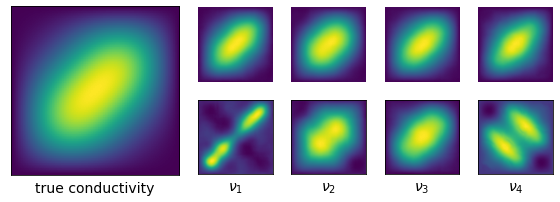

In [297]:
data_path = "../data/FinalExperiments/SameConductivity/Poisson_n70_L100.h5"

sample_number = 300 # I also used 100
f = h5py.File(data_path)
# True Conductivity
fig = plt.figure(figsize=(8, 3))
ax_big = plt.subplot2grid((2, 6), (0, 0), rowspan=2, colspan=2)
ax_big.imshow(f[f'train1/sample_{sample_number}/output'][:])  
ax_big.set_xticks([])
ax_big.set_yticks([])
ax_big.set_xlabel('true conductivity',labelpad=6)

model_numbers = [1,3,4,5]
idx = 0
for model_number in model_numbers:
    # Load Trained Model
    model_name = f"DBC_Train{model_number}"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torch.load(model_name + "/model.pkl", map_location=torch.device(device))

    # PROVIDING IN-DISTRIBUTION DBC and NBC
    # Get Data
    dbcs = torch.from_numpy(f[f'train{model_number}/sample_{sample_number}/input_dbc'][:].astype(np.float32))
    dbcs = dbcs.view(1, 4, 69, 100).permute(3, 0, 1, 2)
    dbcs = dbcs[:,:,:,:68] # Cut corners to match nbcs size
    nbcs = torch.from_numpy(f[f'train{model_number}/sample_{sample_number}/input_nbc'][:].astype(np.float32))
    nbcs = nbcs.view(1, 4, 68, 100).permute(3, 0, 1, 2)
    sample_concat = torch.cat((dbcs,nbcs), 2)
    sample_concat = torch.reshape(sample_concat, (1, 100, 1, 8, 68)) # reshaped so it is like "1 batch"
    # Transfer to GPU
    if torch.cuda.is_available():
        # Move the data to GPU since model is already on GPU
        sample_concat, grid = sample_concat.cuda(), grid.cuda() 
    # Predict conductivity from DtN
    predicted_conductivity = model(sample_concat, grid)
    if torch.cuda.is_available():
        # Move the data back to CPU
        sample_concat, grid = sample_concat.cpu(), grid.cpu()
        predicted_conductivity = predicted_conductivity.cpu()
    predicted_conductivity = torch.reshape(predicted_conductivity,(70,70)).detach().numpy()
    # Plot
    ax = plt.subplot2grid((2, 6), (0, idx+2))
    ax.imshow(predicted_conductivity)
    ax.axis('off')
    
    # PROVIDING OOD DBC and NBC
    # Get Data
    dbcs = torch.from_numpy(f[f'test/sample_{sample_number}/input_dbc'][:].astype(np.float32))
    dbcs = dbcs.view(1, 4, 69, 100).permute(3, 0, 1, 2)
    dbcs = dbcs[:,:,:,:68] # Cut corners to match nbcs size
    nbcs = torch.from_numpy(f[f'test/sample_{sample_number}/input_nbc'][:].astype(np.float32))
    nbcs = nbcs.view(1, 4, 68, 100).permute(3, 0, 1, 2)
    sample_concat = torch.cat((dbcs,nbcs), 2)
    sample_concat = torch.reshape(sample_concat, (1, 100, 1, 8, 68)) # reshaped so it is like "1 batch"
    # Transfer to GPU
    if torch.cuda.is_available():
        # Move the data to GPU since model is already on GPU
        sample_concat, grid = sample_concat.cuda(), grid.cuda() 
    # Predict conductivity from DtN
    predicted_conductivity = model(sample_concat, grid)
    if torch.cuda.is_available():
        # Move the data back to CPU
        sample_concat, grid, = sample_concat.cpu(), grid.cpu()
        predicted_conductivity = predicted_conductivity.cpu()
    predicted_conductivity = torch.reshape(predicted_conductivity,(70,70)).detach().numpy()
    # Plot
    ax = plt.subplot2grid((2, 6), (1, idx+2))
    ax.imshow(predicted_conductivity)
    ax.set_xlabel(f'$\\nu_{idx+1}$',labelpad=6)
    ax.set_xticks([])
    ax.set_yticks([])
    
    idx += 1
plt.tight_layout()
plt.show()
fig.savefig('OODvsID2.pdf')

In [8]:
# OOD vs ID Table
data_path = "../data/FinalExperiments/SameConductivity/Poisson_n70_L100.h5"
f = h5py.File(data_path)

model_numbers = [1,3,4,5]
errors = np.zeros((1024,2,4))

for sample_number in range(1024):
    if sample_number % 50 == 0:
        print(f'Working on sample {sample_number+1}')

    # True Conductivity
    true_conductivity = f[f'train1/sample_{sample_number}/output'][:]  

    idx = 0
    for model_number in model_numbers:
        # Load Trained Model
        model_name = f"DBC_Train{model_number}"
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = torch.load(model_name + "/model.pkl", map_location=torch.device(device))

        # PROVIDING IN-DISTRIBUTION DBC and NBC
        # Get Data
        dbcs = torch.from_numpy(f[f'train{model_number}/sample_{sample_number}/input_dbc'][:].astype(np.float32))
        dbcs = dbcs.view(1, 4, 69, 100).permute(3, 0, 1, 2)
        dbcs = dbcs[:,:,:,:68] # Cut corners to match nbcs size
        nbcs = torch.from_numpy(f[f'train{model_number}/sample_{sample_number}/input_nbc'][:].astype(np.float32))
        nbcs = nbcs.view(1, 4, 68, 100).permute(3, 0, 1, 2)
        sample_concat = torch.cat((dbcs,nbcs), 2)
        sample_concat = torch.reshape(sample_concat, (1, 100, 1, 8, 68)) # reshaped so it is like "1 batch"
        # Transfer to GPU
        if torch.cuda.is_available():
            # Move the data to GPU since model is already on GPU
            sample_concat, grid = sample_concat.cuda(), grid.cuda() 
        # Predict conductivity from DtN
        predicted_conductivity = model(sample_concat, grid)
        if torch.cuda.is_available():
            # Move the data back to CPU
            sample_concat, grid = sample_concat.cpu(), grid.cpu()
            predicted_conductivity = predicted_conductivity.cpu()
        predicted_conductivity = torch.reshape(predicted_conductivity,(70,70)).detach().numpy()
        errors[sample_number,0,idx] += np.linalg.norm(true_conductivity - predicted_conductivity,ord=2)/np.linalg.norm(true_conductivity,ord=2)
        

        # PROVIDING OOD DBC and NBC
        # Get Data
        dbcs = torch.from_numpy(f[f'test/sample_{sample_number}/input_dbc'][:].astype(np.float32))
        dbcs = dbcs.view(1, 4, 69, 100).permute(3, 0, 1, 2)
        dbcs = dbcs[:,:,:,:68] # Cut corners to match nbcs size
        nbcs = torch.from_numpy(f[f'test/sample_{sample_number}/input_nbc'][:].astype(np.float32))
        nbcs = nbcs.view(1, 4, 68, 100).permute(3, 0, 1, 2)
        sample_concat = torch.cat((dbcs,nbcs), 2)
        sample_concat = torch.reshape(sample_concat, (1, 100, 1, 8, 68)) # reshaped so it is like "1 batch"
        # Transfer to GPU
        if torch.cuda.is_available():
            # Move the data to GPU since model is already on GPU
            sample_concat, grid = sample_concat.cuda(), grid.cuda() 
        # Predict conductivity from DtN
        predicted_conductivity = model(sample_concat, grid)
        if torch.cuda.is_available():
            # Move the data back to CPU
            sample_concat, grid, = sample_concat.cpu(), grid.cpu()
            predicted_conductivity = predicted_conductivity.cpu()
        predicted_conductivity = torch.reshape(predicted_conductivity,(70,70)).detach().numpy()
        errors[sample_number,1,idx] += np.linalg.norm(true_conductivity - predicted_conductivity,ord=2)/np.linalg.norm(true_conductivity,ord=2)

        idx += 1
print('done')

Working on sample 1


/tmp/ipykernel_3826941/971296026.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_name + "/model.pkl", map_location=torch.device(device))


Working on sample 51
Working on sample 101
Working on sample 151
Working on sample 201
Working on sample 251
Working on sample 301
Working on sample 351
Working on sample 401
Working on sample 451
Working on sample 501
Working on sample 551
Working on sample 601
Working on sample 651
Working on sample 701
Working on sample 751
Working on sample 801
Working on sample 851
Working on sample 901
Working on sample 951
Working on sample 1001
done


In [9]:
mean_errors = np.mean(errors, axis=0)
std_errors = np.std(errors, axis=0)
print(mean_errors)
print(std_errors)

[[0.03390301 0.08130737 0.02147761 0.017021  ]
 [0.79633539 0.07814442 0.06595157 0.13231561]]
[[0.01894407 0.02845798 0.01023548 0.00909863]
 [0.25122282 0.04651173 0.03804081 0.04663832]]


In [94]:
predicted_conductivity

array([[1.0178823, 1.0210005, 1.0165269, ..., 1.0247515, 1.0292016,
        1.0278647],
       [1.0205656, 1.0234429, 1.019422 , ..., 1.0228791, 1.0314752,
        1.0294679],
       [1.0189396, 1.0183815, 1.0115849, ..., 1.0144144, 1.0251756,
        1.0259912],
       ...,
       [1.0244898, 1.0168539, 1.0029709, ..., 0.999725 , 1.0092847,
        1.0115845],
       [1.0243319, 1.0198224, 1.0059396, ..., 1.0037946, 1.0104764,
        1.0125706],
       [1.0213555, 1.0171759, 1.0066074, ..., 1.0113653, 1.0157696,
        1.0145912]], dtype=float32)

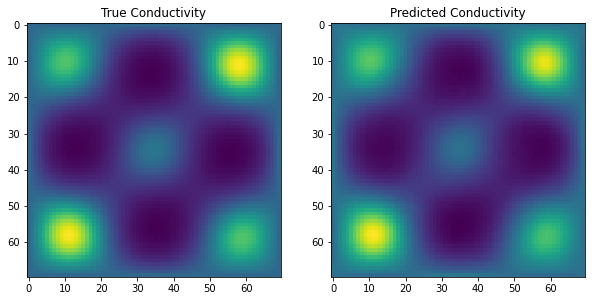

In [265]:
# In Distribution
data_path = "../data/FinalExperiments/MultiTrain/Poisson_n70_L100_MultiTrain.h5"

model_number = 1
sample_number = 100

# Load Trained ModeL
model_name = f"DBC_Train{model_number}"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(model_name + "/model.pkl", map_location=torch.device(device))

# Get Data
dbcs = torch.from_numpy(f[f'train{model_number}/sample_{sample_number}/input_dbc'][:].astype(np.float32))
dbcs = dbcs.view(1, 4, 69, 100).permute(3, 0, 1, 2)
dbcs = dbcs[:,:,:,:68] # Cut corners to match nbcs size

nbcs = torch.from_numpy(f[f'train{model_number}/sample_{sample_number}/input_nbc'][:].astype(np.float32))
nbcs = nbcs.view(1, 4, 68, 100).permute(3, 0, 1, 2)

sample_concat = torch.cat((dbcs,nbcs), 2)
sample_concat = torch.reshape(sample_concat, (1, 100, 1, 8, 68)) # reshaped so it is like "1 batch"

true_conductivity = torch.from_numpy(f[f'train{model_number}/sample_{sample_number}/output'][:].astype(np.float32))
if torch.cuda.is_available():
    # Move the data to GPU since model is already on GPU
    sample_concat, grid, true_conductivity = sample_concat.cuda(), grid.cuda(), true_conductivity.cuda() 

# Predict conductivity from DtN
predicted_conductivity = model(sample_concat, grid)
if torch.cuda.is_available():
    # Move the data back to CPU
    sample_concat, grid = sample_concat.cpu(), grid.cpu()
    true_conductivity, predicted_conductivity = true_conductivity.cpu(), predicted_conductivity.cpu()

predicted_conductivity = torch.reshape(predicted_conductivity,(70,70)).detach().numpy()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(true_conductivity)
ax1.set_title('True Conductivity')
ax2.imshow(predicted_conductivity)
ax2.set_title('Predicted Conductivity')
plt.show()

In [238]:
# Compute average relative L2 In-distribution error
data_path = "../data/FinalExperiments/MultiTrain/Poisson_n70_L100_MultiTrain.h5"

N_samples = 100 # Number of samples used to compute average error for each model
IDerrors = np.zeros((5,N_samples))
for model_number in range(1,6):
    for sample_number in range(N_samples):
        # Load Trained ModeL
        model_name = f"DBC_Train{model_number}"
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = torch.load(model_name + "/model.pkl", map_location=torch.device(device))

        # Get Data
        dbcs = torch.from_numpy(f[f'train{model_number}/sample_{sample_number}/input_dbc'][:].astype(np.float32))
        dbcs = dbcs.view(1, 4, 69, 100).permute(3, 0, 1, 2)
        dbcs = dbcs[:,:,:,:68] # Cut corners to match nbcs size

        nbcs = torch.from_numpy(f[f'train{model_number}/sample_{sample_number}/input_nbc'][:].astype(np.float32))
        nbcs = nbcs.view(1, 4, 68, 100).permute(3, 0, 1, 2)

        sample_concat = torch.cat((dbcs,nbcs), 2)
        sample_concat = torch.reshape(sample_concat, (1, 100, 1, 8, 68)) # reshaped so it is like "1 batch"

        true_conductivity = torch.from_numpy(f[f'train{model_number}/sample_{sample_number}/output'][:].astype(np.float32))
        if torch.cuda.is_available():
            # Move the data to GPU since model is already on GPU
            sample_concat, grid, true_conductivity = sample_concat.cuda(), grid.cuda(), true_conductivity.cuda() 

        # Predict conductivity from DtN
        predicted_conductivity = model(sample_concat, grid)
        if torch.cuda.is_available():
            # Move the data back to CPU
            sample_concat, grid = sample_concat.cpu(), grid.cpu()
            true_conductivity, predicted_conductivity = true_conductivity.cpu(), predicted_conductivity.cpu()

        predicted_conductivity = torch.reshape(predicted_conductivity,(70,70)).detach().numpy()
        IDerrors[model_number-1,sample_number] = torch.norm(true_conductivity - predicted_conductivity,p=2)/torch.norm(true_conductivity,p=2)
np.mean(IDerrors,axis=1)

array([0.03404427, 0.38072769, 0.09327254, 0.0256146 , 0.02040316])

Training with  4096  samples
Below is Sample 6 using model Train1.
The relative L2 error is 53.6036%.


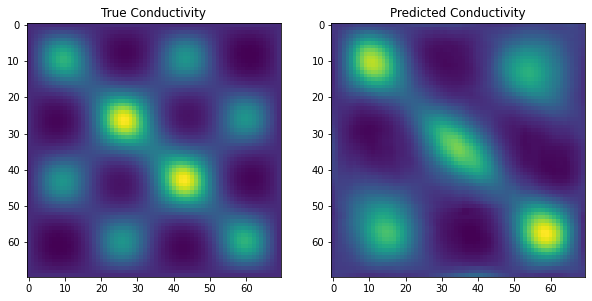

Training with  4096  samples
Below is Sample 6 using model Train2.
The relative L2 error is 52.5238%.


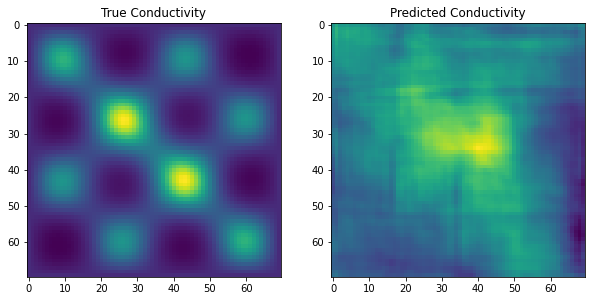

Training with  4096  samples
Below is Sample 6 using model Train3.
The relative L2 error is 17.5688%.


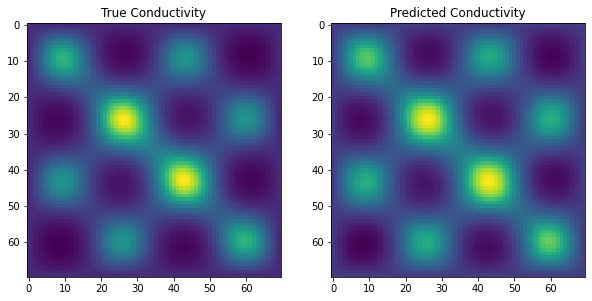

Training with  4096  samples
Below is Sample 6 using model Train4.
The relative L2 error is 11.0586%.


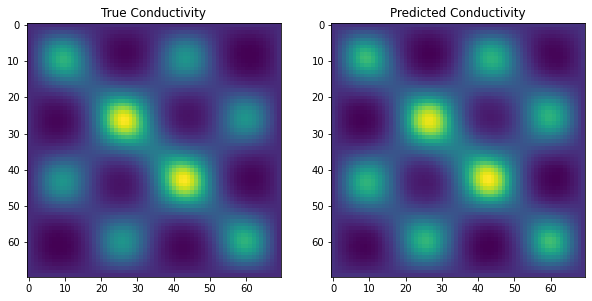

Training with  4096  samples
Below is Sample 6 using model Train5.
The relative L2 error is 20.951%.


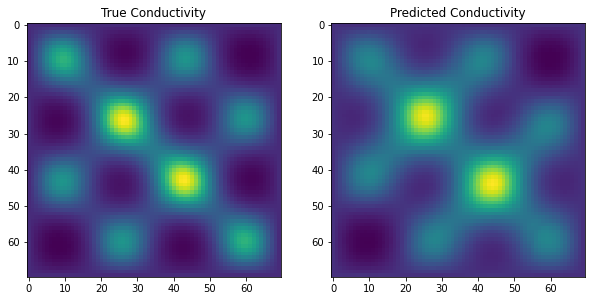

In [153]:
# Out-of-distribution
data_path = "../data/FinalExperiments/Train1/Poisson_n70_L100.h5"
for i in range(1,6):

    model_name = f"DBC_Train{i}"
    sample_number = 6
    
    [true_conductivity, predicted_conductivity, sample_number] = get_output(model_name, data_path,sample_number)

    error = torch.norm(true_conductivity - predicted_conductivity,p=2)/torch.norm(true_conductivity,p=2)
    print(f"Below is Sample {sample_number} using model Train{i}.")
    print(f"The relative L2 error is {round(float(100*error),4)}%.")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(true_conductivity)
    ax1.set_title('True Conductivity')
    ax2.imshow(predicted_conductivity)
    ax2.set_title('Predicted Conductivity')
    plt.show()

In [157]:
# Compute Average Relative L2 OOD Error
data_path = "../data/FinalExperiments/Train1/Poisson_n70_L100.h5"
N_test = 100 # We'll just do 100 out of the 2048 testing samples
OODerrors = np.zeros((5,N_test)) # Number of Models x Number of Test samples
for sample_number in range(N_test):
    for i in range(1,6):

        model_name = f"DBC_Train{i}"

        [true_conductivity, predicted_conductivity, sample_number] = get_output(model_name, data_path,sample_number)

        OODerrors[i-1,sample_number] = torch.norm(true_conductivity - predicted_conductivity,p=2)/torch.norm(true_conductivity,p=2)
OODerrors

Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with  4096  samples
Training with 

array([[0.69043988, 1.24130595, 0.66782373, 1.4747324 , 0.79181844,
        1.65672696, 0.6913712 , 0.92822361, 1.04764307, 0.89939582,
        0.95561153, 0.95881766, 0.78562778, 0.96884316, 1.79458761,
        1.15423834, 1.41136551, 1.73542488, 0.9175449 , 1.23533261,
        0.75130796, 0.71928304, 0.61590487, 0.76627171, 1.40411639,
        0.82340318, 0.7395618 , 1.2556262 , 0.6787529 , 1.00139976,
        0.73091835, 1.14298248, 0.88405108, 1.09009027, 1.02695811,
        0.79709387, 1.54159331, 0.7109251 , 1.43467808, 1.0131011 ,
        1.16528845, 1.62561071, 0.82555676, 1.67055774, 1.3323468 ,
        1.26428652, 0.82209373, 0.85686177, 0.9090246 , 0.84741408,
        0.49426481, 1.52314699, 0.93036288, 1.31010485, 0.61172092,
        0.66093135, 0.74972785, 0.73000968, 0.96834224, 0.70903528,
        0.59243226, 0.94484496, 0.79321831, 1.37217593, 0.95045942,
        0.88083303, 0.72318935, 0.35062334, 0.70576543, 1.79984438,
        1.27343917, 0.48330969, 1.46082628, 0.54